# BIT数据挖掘-离群点分析与异常检测

## 数据集：wine

In [2]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
from sklearn.utils import shuffle

# 模型
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF

# 模型评估标准
from sklearn.utils import column_or_1d
from sklearn.utils import check_consistent_length
from sklearn.metrics import roc_auc_score
from pyod.utils.utility import precision_n_scores

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

### 1. 离群点分析算法

Clustering Based Local Outiler Factor

* 该算法将数据分为小聚类簇和大聚类簇，离群得分基于数据点所属的聚类簇的大小来计算，距离计算方式为到最近大聚类簇的距离。

Feature Bagging

* 该算法是一个特征集合检测器，它在数据集的一系列子集上拟合了大量的基准检测器，它使用平均或者其他结合方法来提高预测准确率

* 默认使用LOF(Local Outiler Factor)作为基准评估器，但是KNN，ABOD都可以作为基准检测器

* Feature Bagging 首先通过随机选取特征子集来构建n个子样本，使得基准评估器更具有多样性，最终，通过取所有基准评估器的平均或者最大值来预测得分。

Histogram-based Outiler Detection

* 该算法是一种高效的无监督方法，它假设特征之间独立，然后通过构建直方图来计算离群得分

* 该算法效率高，但是会让精度下降

Isolation Forest

* 内部使用sklearn，该算法使用一个集合的树来完成数据分区。孤立森林提供一个离群得分来判定一个数据点在结构中有多孤立，其离群得分用来将它与正常观测数据区分开来。

* 孤立森林在多维数据上表现很好

KNN

* 对于任意数据点，其到第k个邻居的距离可以作为其离群得分
* PyOD提供三种不同的KNN检测器
    * Largest: 使用第k个邻居的距离来作为离群得分
    * Mean: 使用全部k个邻居的平均距离作为离群得分
    * Median: 使用k个邻居的距离的中位数作为离群得分

In [3]:
def evaluate(y, y_pred):
    """Utility function for evaluating and printing the results for examples.
    Default metrics include ROC and Precision @ n
    Parameters
    ----------
    y : list or numpy array of shape (n_samples,)
        The ground truth. Binary (0: inliers, 1: outliers).
    y_pred : list or numpy array of shape (n_samples,)
        The raw outlier scores as returned by a fitted model.
    """

    y = column_or_1d(y)
    y_pred = column_or_1d(y_pred)
    check_consistent_length(y, y_pred)

    return np.round(roc_auc_score(y, y_pred), decimals=4), np.round(precision_n_scores(y, y_pred), decimals=4)

In [4]:
def outlier_detection(X_train, y_train, X_test, y_test, outliers_fraction, random_state, train_roc, train_prn, test_roc, test_prn):
    classifiers = {
        "CBLOF":CBLOF(contamination=outliers_fraction, check_estimator=False, random_state=random_state),
        "Feature Bagging":FeatureBagging(LOF(n_neighbors=35), check_estimator=False, random_state=random_state),
        "HBOS":HBOS(contamination=outliers_fraction),
        "Isolation Forest":IForest(contamination=outliers_fraction, random_state=random_state),
        "KNN":KNN(contamination=outliers_fraction),
        "Average KNN":KNN(method='mean', contamination=outliers_fraction)
    }

    for i, (clf_name, clf) in enumerate(classifiers.items()):
        # 模型训练
        clf.fit(X_train)
        # 返回未知数据上的异常值 (分值越大越异常)
        y_train_scores = clf.decision_scores_
        
        # 模型预测
        y_test_scores = clf.decision_function(X_test)

        # 模型评估
        roc_train, prn_train = evaluate(y_train, y_train_scores)
        roc_test, prn_test = evaluate(y_test, y_test_scores)
        
        train_roc[clf_name].append(roc_train)
        train_prn[clf_name].append(prn_train)
        test_roc[clf_name].append(roc_test)
        test_prn[clf_name].append(prn_test)

### 2. benchmark子数据集

因为原数据集的离群点比例太高，不符合通常离群点出现的规律，而每个benchmark的离群点比例是10%左右，因此，离群点检测算法只运行在benchmark子数据集上

#### 2.1 读取数据

In [5]:
basic_path = "wine/benchmarks/"
file_list = os.listdir(basic_path)
print("wine benchmarks 子数据集个数：{}".format(len(file_list)))

wine benchmarks 子数据集个数：1210


#### 2.2 离群点检测

In [6]:
# 训练集上模型评估结果
train_roc = {
    'CBLOF': [],
    'Feature Bagging': [],
    'HBOS': [],
    'Isolation Forest': [],
    'KNN': [],
    'Average KNN': []
}
train_prn = {
    'CBLOF': [],
    'Feature Bagging': [],
    'HBOS': [],
    'Isolation Forest': [],
    'KNN': [],
    'Average KNN': []
}
# 测试集上模型评估结果
test_roc = {
    'CBLOF': [],
    'Feature Bagging': [],
    'HBOS': [],
    'Isolation Forest': [],
    'KNN': [],
    'Average KNN': []
}
test_prn = {
    'CBLOF': [],
    'Feature Bagging': [],
    'HBOS': [],
    'Isolation Forest': [],
    'KNN': [],
    'Average KNN': []
}

In [7]:
def train_test_split(X, y, test_size, pos_neg_scale):
    X_train, X_test, y_train, y_test = [], [], [], []
    test_neg_size = int(test_size * pos_neg_scale)
    test_pos_size = test_size - test_neg_size
    i = 0
    for i in range(len(y)):
        # 正样本
        if y[i] == 0 and test_pos_size > 0:
            X_test.append(X[i])
            y_test.append(y[i])
            test_pos_size -= 1
        # 负样本
        elif y[i] == 1 and test_neg_size > 0:
            # 负样本
            X_test.append(X[i])
            y_test.append(y[i])
            test_neg_size -= 1
        # test数据加完，把剩余数据仍训练集里面
        else:
            X_train.append(X[i])
            y_train.append(y[i])
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [8]:
for file in tqdm(file_list):
    try:
        random_state = np.random.RandomState(10)
        columns = [
            'fixed.acidity', 'volatile.acidity', 'citric.acid', 'residual.sugar',
            'chlorides', 'free.sulfur.dioxide', 'total.sulfur.dioxide', 'density',
            'pH', 'sulphates', 'alcohol', 'ground.truth'
        ]
        # 数据读取
        df = pd.read_csv(basic_path + file)
        df = df[columns]
        df = shuffle(df, random_state=random_state)
        X = np.array(df[columns[:-1]]).tolist()
        y = np.array(df[columns[-1]].map({"nominal": 0, "anomaly": 1})).tolist()

        # 正负样本比例
        outliers_fraction = (sum(y) * 1.0) / len(y)
        # pyod算法中contamination阈值在[0, 0.5]之间
        # 离群点数据量太大，分析意义不大，丢弃
        if outliers_fraction > 0.5:
            continue

        # 训练集，测试集划分
        test_size = df.shape[0] * 0.3
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size, outliers_fraction)

        # 离群点分析
        outlier_detection(X_train, y_train, X_test, y_test, outliers_fraction,
                          random_state, train_roc, train_prn, test_roc, test_prn)
    except:
        continue

100%|██████████| 1210/1210 [48:29<00:00,  2.40s/it]


#### 2.3 离群点结果分析

通过直方图可视化在训练集、测试集上评测结果ROC，查看ROC scores分布情况

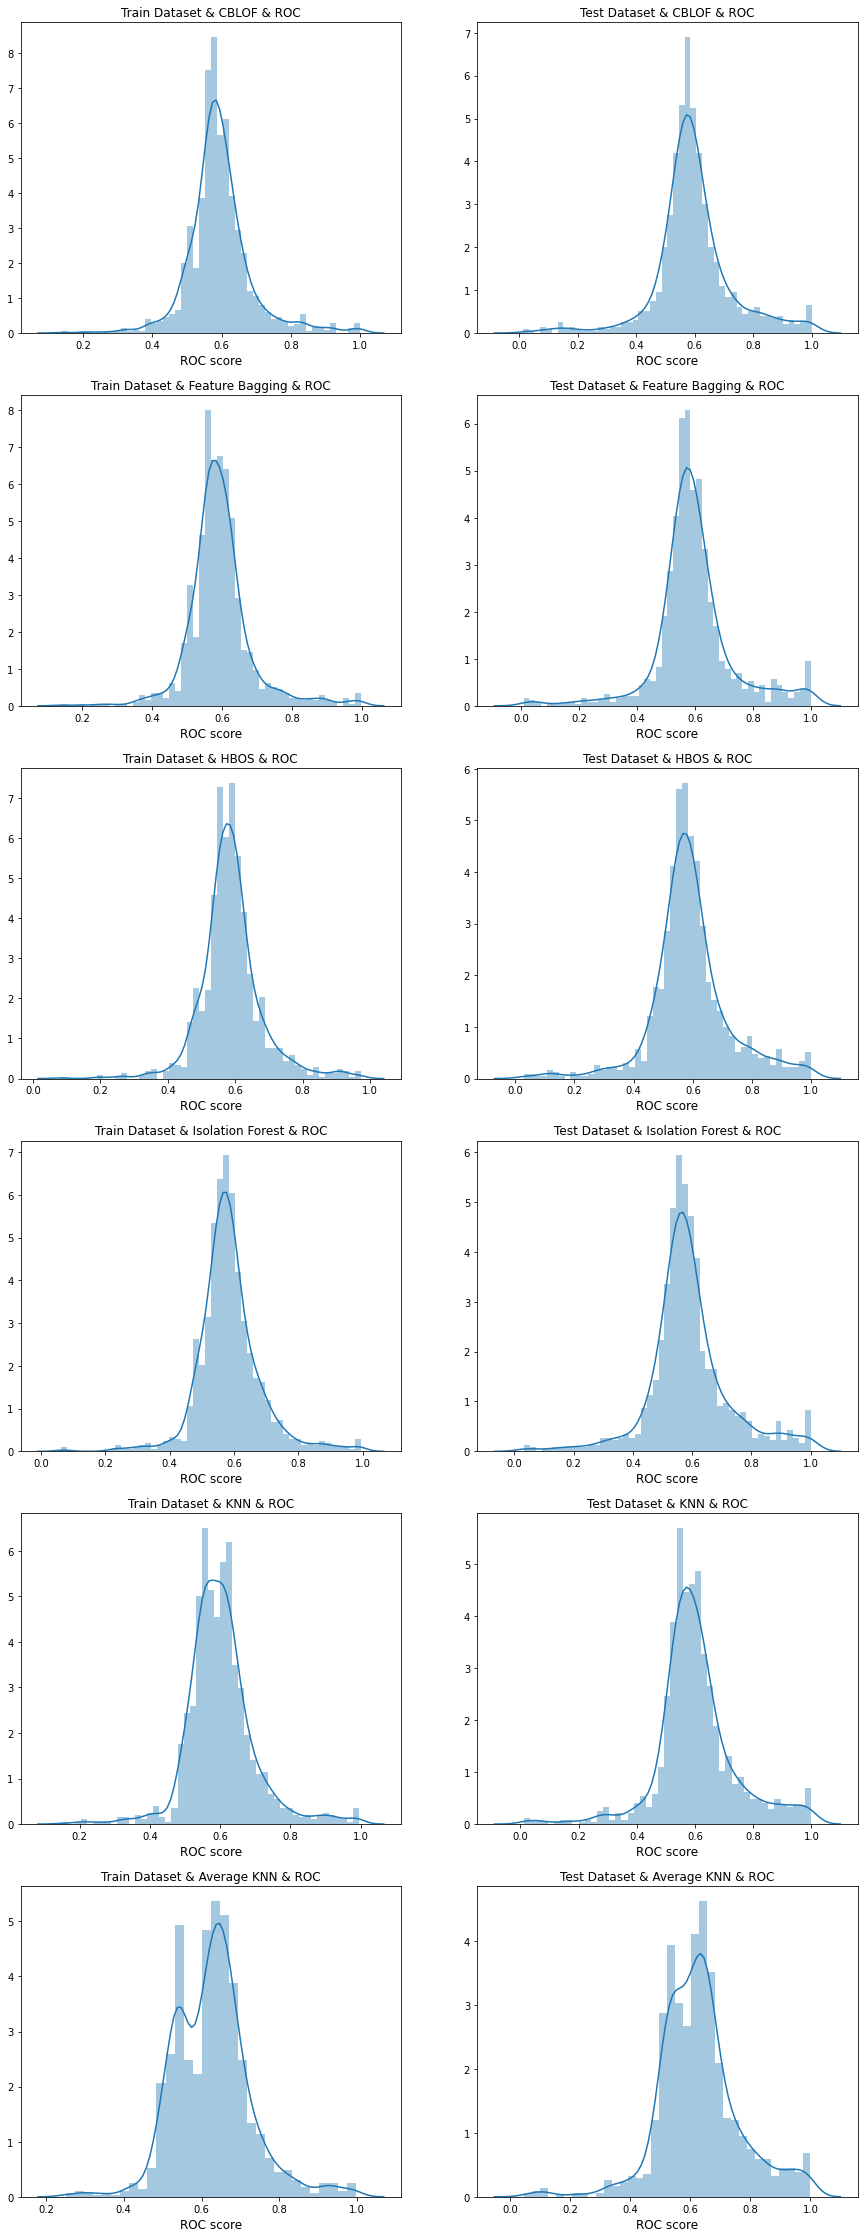

In [53]:
# 可视化评测结果:AUC
x = [i for i in range(len(train_roc['KNN']))]

plt.figure(figsize=(15, 40))

for i, key in zip(range(1, 12, 2), train_roc):
    plt.subplot(6, 2, i)
    plt.title("Train Dataset & "+ key + " & ROC", fontsize=12)
    sns.distplot(train_roc[key])

    plt.xlabel("ROC score", fontsize=12)

    plt.subplot(6, 2, i+1)
    plt.title("Test Dataset & "+ key + " & ROC", fontsize=12)
    sns.distplot(test_roc[key])

    plt.xlabel("ROC score", fontsize=12)

plt.show()

通过直方图可视化在训练集、测试集上评测结果PRN，查看PRN scores 分布情况

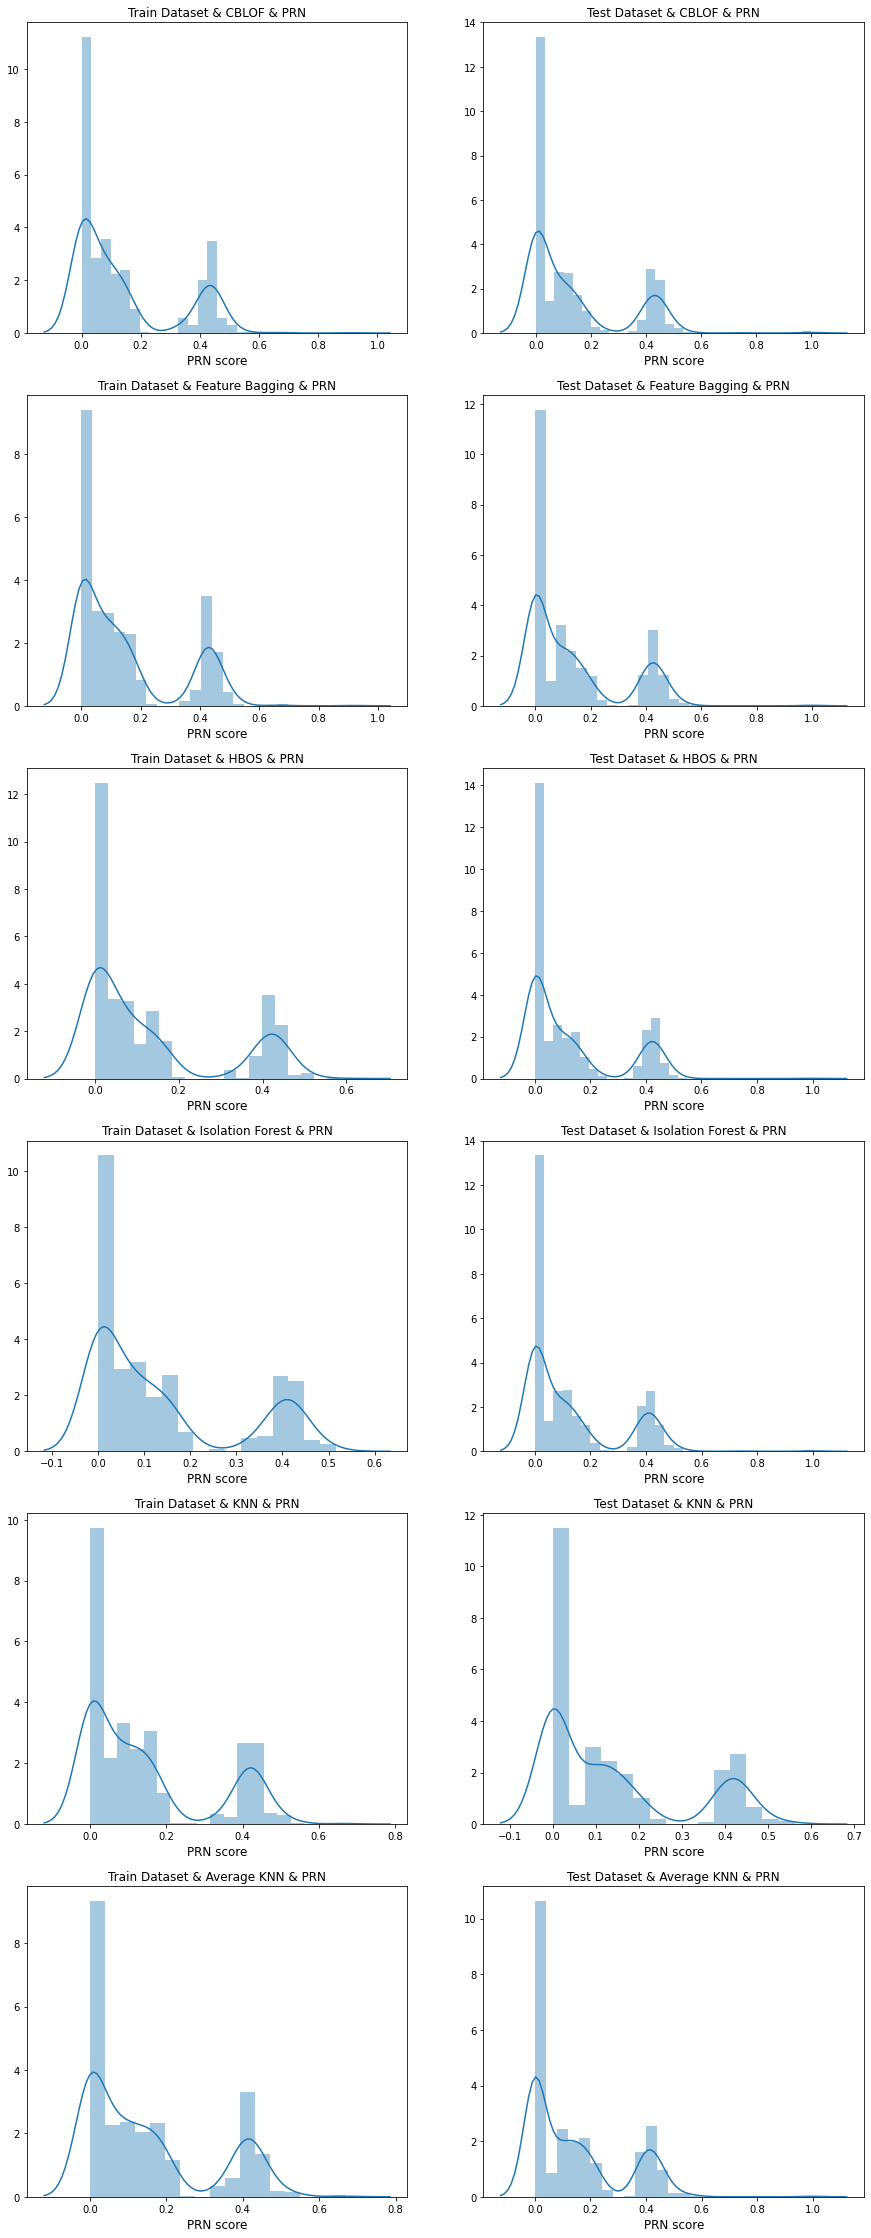

In [48]:
# 可视化评测结果:PRN
x = [i for i in range(len(train_prn['KNN']))]

plt.figure(figsize=(15, 40))

for i, key in zip(range(1, 12, 2), train_roc):
    plt.subplot(6, 2, i)
    plt.title("Train Dataset & "+ key + " & PRN", fontsize=12)
    sns.distplot(train_prn[key])

    plt.xlabel("PRN score", fontsize=12)

    plt.subplot(6, 2, i+1)
    plt.title("Test Dataset & "+ key + " & PRN", fontsize=12)
    sns.distplot(test_prn[key])

    plt.xlabel("PRN score", fontsize=12)

plt.show()

计算不同算法得到的评测结果 ROC、PRN scores 平均值

In [60]:
# 计算不同算法 ROC，PRN scores 平均值
index = ['train ROC', 'test  ROC', 'train PRN', 'test  PRN']
columns = [key for key in train_roc]

data = [[round(np.mean(train_roc[key]), 4) for key in columns]]
data.append([round(np.mean(test_roc[key]), 4) for key in columns])
data.append([round(np.mean(train_prn[key]), 4) for key in columns])
data.append([round(np.mean(test_prn[key]), 4) for key in columns])

res = pd.DataFrame(data=data, columns=columns, index=index)
print(res)

            CBLOF  Feature Bagging   HBOS   Isolation Forest    KNN   \
train ROC  0.5943      0.5928       0.5878       0.5852       0.6017   
test  ROC  0.5958      0.5952       0.5920       0.5904       0.6041   
train PRN  0.1433      0.1492       0.1347       0.1385       0.1474   
test  PRN  0.1357      0.1398       0.1297       0.1318       0.1390   

           Average KNN  
train ROC    0.6269     
test  ROC    0.6290     
train PRN    0.1515     
test  PRN    0.1449     


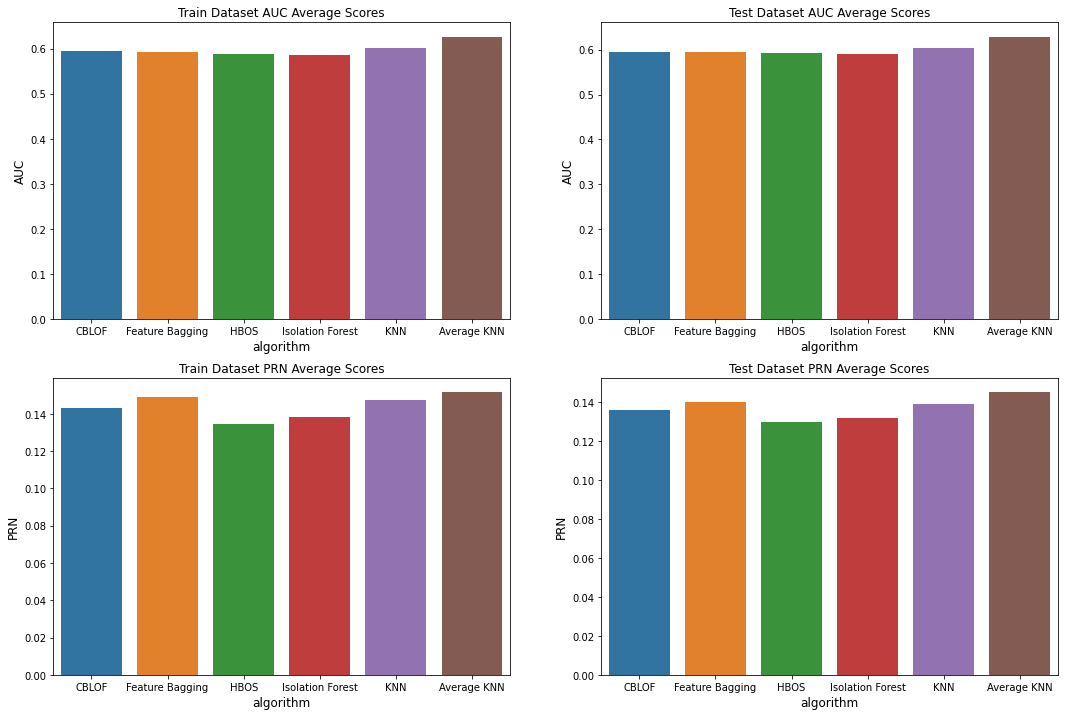

In [52]:
# 可视化不同算法 AUC，PRN scores 平均值
plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 1)
plt.title('Train Dataset AUC Average Scores', fontsize=12)
sns.barplot(x=[key for key in train_roc.keys()], y=[np.mean(item) for item in train_roc.values()])

plt.xlabel('algorithm', fontsize=12)
plt.ylabel('AUC', fontsize=12)


plt.subplot(2, 2, 2)
plt.title('Test Dataset AUC Average Scores', fontsize=12)
sns.barplot(x=[key for key in test_roc.keys()], y=[np.mean(item) for item in test_roc.values()])

plt.xlabel('algorithm', fontsize=12)
plt.ylabel('AUC', fontsize=12)


plt.subplot(2, 2, 3)
plt.title('Train Dataset PRN Average Scores', fontsize=12)
sns.barplot(x=[key for key in train_prn.keys()], y=[np.mean(item) for item in train_prn.values()])

plt.xlabel('algorithm', fontsize=12)
plt.ylabel('PRN', fontsize=12)


plt.subplot(2, 2, 4)
plt.title('Test Dataset PRN Average Scores', fontsize=12)
sns.barplot(x=[key for key in test_prn.keys()], y=[np.mean(item) for item in test_prn.values()])

plt.xlabel('algorithm', fontsize=12)
plt.ylabel('PRN', fontsize=12)

plt.show()

#### 本实验共使用了6个模型进行离群点分析，根据实验结果可知：在wine数据集中，Average KNN模型检测效果最好。